In [2]:
%load_ext autoreload
%autoreload 2

In [15]:

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.PPO.PPO import PPO, PPOContinuous
import pdb
import time

# env_name = "BipedalWalker-v2"
env_name = "Pendulum-v0"
env = gym.make(env_name)

env.seed(1234)

state_size = env.observation_space.shape[0]
action_size =env.action_space.shape[0]

print(state_size)
print(action_size)

# PPO Settings
update_every = 2000
num_learn = 4
win_condition = 0

# Agent settings
hidden_size=256
epsilon=0.2
entropy_beta=0.01
gamma=0.99
lr=0.0003

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

3
1


In [16]:
agent = PPOContinuous(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)

In [17]:

scores_deque = deque(maxlen=100)
scores = []
average_scores = []
max_score = -np.Inf

def train(n_episodes=2000, max_t=1500):
#   agent = PPO(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)
  steps = 0

  for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    
    for t in range(max_t):
      steps += 1

      actions_tensor, log_prob = agent.act(torch.FloatTensor(state).to(device))
      actions = actions_tensor.cpu().data.numpy().flatten()
      next_state, reward, done, _ = env.step(actions_tensor.cpu().numpy())

      agent.mem.add(torch.FloatTensor(state), actions, reward, log_prob, done)

      # Update 
      state = next_state
      score += reward

      if steps >= update_every:
        start_time = time.time()
        
        agent.learn(num_learn)
        agent.mem.clear()
        steps = 0

#         print("\rLearning Time: {}".format(time.time()-start_time))

      if done:
        break
    
    # Book Keeping
    scores_deque.append(score)
    scores.append(score)
    average_scores.append(np.mean(scores_deque))
      

    print("\rEpisode {}	Average Score: {:.2f}	Score: {:.2f}".format(episode, np.mean(scores_deque), score), end="")

    if episode % 100 == 0:
      print("\rEpisode {}	Average Score: {:.2f}".format(episode, np.mean(scores_deque)))   
#       torch.save(agent.model.state_dict(), "walker_ppo_model_{}.pth".format(episode))
#       torch.save(agent.model_old.state_dict(), "walker_ppo_model_old_{}.pth".format(episode))
    
    if np.mean(scores_deque) > win_condition:
      print("\rEnvironment Solved in {} episodes!".format(episode))
      break


  return scores, average_scores

scores, average_scores = train()

Episode 100	Average Score: -1135.68	Score: -1126.97
Episode 200	Average Score: -1149.31	Score: -1091.55
Episode 300	Average Score: -1129.90	Score: -1239.33
Episode 400	Average Score: -1153.77	Score: -1217.58
Episode 500	Average Score: -1112.14	Score: -1050.32
Episode 600	Average Score: -1139.47	Score: -1152.26
Episode 700	Average Score: -1132.01	Score: -1005.59
Episode 800	Average Score: -1106.13	Score: -1017.17
Episode 900	Average Score: -1127.06	Score: -1165.95
Episode 1000	Average Score: -1150.73	Score: -1443.29
Episode 1100	Average Score: -1124.13	Score: -771.518
Episode 1200	Average Score: -1158.05	Score: -1082.17
Episode 1300	Average Score: -1109.13	Score: -949.721
Episode 1400	Average Score: -1130.15	Score: -1019.57
Episode 1500	Average Score: -1105.79	Score: -886.552
Episode 1600	Average Score: -1114.61	Score: -1452.29
Episode 1700	Average Score: -1088.50	Score: -997.345
Episode 1800	Average Score: -1053.30	Score: -911.986
Episode 1900	Average Score: -1101.82	Score: -908.075
Ep

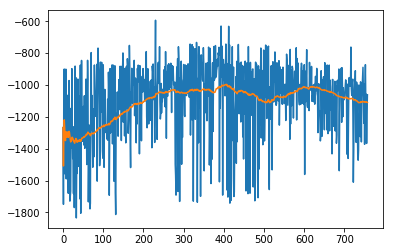

In [8]:
plt.plot(scores)
plt.plot(average_scores)

In [ ]:
for episode in range(0):
    state = env.reset()
    score = 0
    input()

    for t in range(1500):
        actions_tensor, log_prob = agent.act(torch.FloatTensor(state))
        actions = actions_tensor.cpu().data.numpy().flatten()
        next_state, reward, done, _ = env.step(actions_tensor)

        
        score += reward
        
        env.render()
        
        if done:
            break;
        
        state = next_state

    print(score)
env.close()